In [ ]:
### 1. INITIALISATION - Imports et configuration du dataset ###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pathlib import Path
from io import BytesIO
from PIL import Image

# Configuration du style
plt.style.use('default')
sns.set_palette("husl")

# Détecter l'environnement
IN_COLAB = 'google.colab' in sys.modules

print("="*80)
print("INITIALISATION DU PROJET BIRD CLASSIFICATION")
print("="*80)
print(f"\nEnvironnement : {'Google Colab' if IN_COLAB else 'Python Local'}")

# Variables globales
DRIVE_FOLDER_ID = "1kHTcb7OktpYB9vUaZPLQ3ywXFYMUdQsP"
LOCAL_DATA_PATH = Path("./data")
TRAIN_PATH = LOCAL_DATA_PATH / "train"
VALID_PATH = LOCAL_DATA_PATH / "valid"

# Initialiser dataset_root
dataset_root = None
drive_loader = None

if IN_COLAB:
    from google.colab import drive
    print("\n✓ Mode Google Colab détecté")
    print("  Montage de Google Drive...")
    
    try:
        drive.mount('/content/drive')
        drive_base_path = Path('/content/drive/My Drive')
        
        # Chercher le dataset
        for item in drive_base_path.iterdir():
            if item.is_dir() and (item / 'train').exists():
                dataset_root = item
                print(f"  ✓ Dataset trouvé dans : {item.name}")
                break
        
        if not dataset_root:
            print("  ⚠ Dataset non trouvé dans My Drive")
    except Exception as e:
        print(f"  ⚠ Erreur : {e}")
else:
    print("\n✓ Mode Python Local détecté")
    
    # Vérifier les données locales
    if TRAIN_PATH.exists() and VALID_PATH.exists():
        print(f"  ✓ Données locales trouvées : {LOCAL_DATA_PATH}")
        dataset_root = LOCAL_DATA_PATH
    else:
        print(f"  ⚠ Données locales non trouvées")
        print(f"    Chemin attendu : {LOCAL_DATA_PATH}")
        print(f"    train existe : {TRAIN_PATH.exists()}")
        print(f"    valid existe : {VALID_PATH.exists()}")

print("\n✓ Initialisation terminée !")

c:\Users\tsiba\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.10.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


INITIALISATION DU PROJET BIRD CLASSIFICATION

Environnement : Python Local

✓ Mode Python Local détecté
  ✓ Données locales trouvées : data

✓ Initialisation terminée !


In [ ]:
### 2. ANALYSE DU DATASET - Créer un DataFrame avec les informations ###

print("\n" + "="*80)
print("ANALYSE DU DATASET")
print("="*80)

# Limite d'images par classe    
# MAX_IMAGES_PER_CLASS = 50
MAX_IMAGES_PER_CLASS = 500  # ← LIMITE À 500 IMAGES PAR CLASSE

if dataset_root is None:
    print("\n⚠ Dataset non accessible")
    print("  Exécutez la cellule 1 d'abord et assurez-vous que le dataset est disponible")
else:
    try:
        # Chemins des données
        train_dir = Path(dataset_root) / 'train'
        valid_dir = Path(dataset_root) / 'valid'
        
        # Créer les listes de données
        data = []
        
        # Traiter les données d'entraînement
        print("\n✓ Analyse des données d'entraînement...")
        if train_dir.exists():
            for class_path in sorted(train_dir.iterdir()):
                if class_path.is_dir():
                    images = list(class_path.glob('*.[jJ][pP][gG]')) + \
                            list(class_path.glob('*.[jJ][pP][eE][gG]')) + \
                            list(class_path.glob('*.[pP][nN][gG]'))
                    
                    # Limiter à MAX_IMAGES_PER_CLASS images par classe
                    num_images = min(len(images), MAX_IMAGES_PER_CLASS)
                    
                    data.append({
                        'Classe': class_path.name,
                        'Ensemble': 'Entraînement',
                        "Nombre d'images": num_images,
                        'Chemin': str(class_path)
                    })
        
        # Traiter les données de validation
        print("✓ Analyse des données de validation...")
        if valid_dir.exists():
            for class_path in sorted(valid_dir.iterdir()):
                if class_path.is_dir():
                    images = list(class_path.glob('*.[jJ][pP][gG]')) + \
                            list(class_path.glob('*.[jJ][pP][eE][gG]')) + \
                            list(class_path.glob('*.[pP][nN][gG]'))
                    
                    # Limiter à MAX_IMAGES_PER_CLASS images par classe
                    num_images = min(len(images), MAX_IMAGES_PER_CLASS)
                    
                    data.append({
                        'Classe': class_path.name,
                        'Ensemble': 'Validation',
                        "Nombre d'images": num_images,
                        'Chemin': str(class_path)
                    })
        
        if data:
            # Créer le DataFrame
            df_dataset = pd.DataFrame(data)
            
            # Afficher les statistiques
            print("\n" + "-"*80)
            print("RÉSUMÉ DU DATASET")
            print("-"*80)
            
            n_classes = df_dataset['Classe'].nunique()
            total_images = df_dataset["Nombre d'images"].sum()
            
            print(f"\n📊 Statistiques globales :")
            print(f"   Nombre total de classes : {n_classes}")
            print(f"   Nombre total d'images : {total_images:,}")
            print(f"   Limite par classe : {MAX_IMAGES_PER_CLASS} images")
            
            print(f"\n📈 Répartition par ensemble :")
            stats = df_dataset.groupby('Ensemble').agg({
                'Classe': 'nunique',
                "Nombre d'images": ['sum', 'mean', 'min', 'max']
            })
            stats.columns = ['Nombre de classes', 'Total images', 'Moy/classe', 'Min', 'Max']
            print(stats.to_string())
            
            print(f"\n🏆 Top 5 classes par nombre d'images :")
            top_classes = df_dataset.nlargest(5, "Nombre d'images")[['Classe', 'Ensemble', "Nombre d'images"]]
            print(top_classes.to_string(index=False))
            
            print(f"\n✓ DataFrame créé avec succès !")
            print(f"   Forme : {df_dataset.shape}")
        else:
            print("⚠ Aucune image trouvée dans le dataset")
            df_dataset = None
    
    except Exception as e:
        print(f"\n❌ Erreur lors de l'analyse : {e}")
        df_dataset = None


ANALYSE DU DATASET

✓ Analyse des données d'entraînement...
✓ Analyse des données de validation...

--------------------------------------------------------------------------------
RÉSUMÉ DU DATASET
--------------------------------------------------------------------------------

📊 Statistiques globales :
   Nombre total de classes : 25
   Nombre total d'images : 20,000
   Limite par classe : 500 images

📈 Répartition par ensemble :
              Nombre de classes  Total images  Moy/classe  Min  Max
Ensemble                                                           
Entraînement                 25         12500       500.0  500  500
Validation                   25          7500       300.0  300  300

🏆 Top 5 classes par nombre d'images :
               Classe     Ensemble  Nombre d'images
Asian-Green-Bee-Eater Entraînement              500
  Brown-Headed-Barbet Entraînement              500
         Cattle-Egret Entraînement              500
    Common-Kingfisher Entraînement         

In [ ]:
### 3. ACCÈS GOOGLE DRIVE - Configuration et Data Loader ###

print("\n" + "="*80)
print("CONFIGURATION ACCÈS GOOGLE DRIVE")
print("="*80)

# Installation de gdown (plus fiable)
print("\n✓ Installation des dépendances...")
import subprocess

try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "gdown", "-q"])
    import gdown
    print("  ✓ gdown installé")
    gdown_available = True
except Exception as e:
    print(f"  ⚠ gdown : {e}")
    gdown_available = False

# Classe pour accéder aux données
class BirdDatasetLoader:
    """Classe pour charger et traiter le dataset des oiseaux"""
    
    def __init__(self, data_path=None, drive_id=None):
        self.data_path = Path(data_path) if data_path else LOCAL_DATA_PATH
        self.drive_id = drive_id or DRIVE_FOLDER_ID
        self.train_path = self.data_path / 'train'
        self.valid_path = self.data_path / 'valid'
        self.classes = None
        self.metadata = {}
    
    def load_local_dataset(self):
        """Charge le dataset depuis les fichiers locaux"""
        if not (self.train_path.exists() or self.valid_path.exists()):
            return False
        
        self.metadata = {'source': 'local', 'path': str(self.data_path)}
        return True
    
    def get_classes(self, folder_type='train'):
        """Récupère la liste des classes"""
        path = self.train_path if folder_type == 'train' else self.valid_path
        
        if not path.exists():
            return []
        
        classes = sorted([d.name for d in path.iterdir() if d.is_dir()])
        return classes
    
    def get_images_for_class(self, class_name, folder_type='train'):
        """Récupère les images d'une classe"""
        path = self.train_path if folder_type == 'train' else self.valid_path
        class_path = path / class_name
        
        if not class_path.exists():
            return []
        
        extensions = ('*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG')
        images = []
        for ext in extensions:
            images.extend(class_path.glob(ext))
        
        return sorted(images)
    
    def load_image(self, image_path, size=None):
        """Charge une image"""
        try:
            img = Image.open(image_path)
            
            if size:
                img = img.resize(size, Image.Resampling.LANCZOS)
            
            return np.array(img)
        except Exception as e:
            print(f"❌ Erreur chargement {image_path} : {e}")
            return None
    
    def get_dataset_info(self):
        """Récupère les informations du dataset"""
        info = {
            'train_classes': self.get_classes('train'),
            'valid_classes': self.get_classes('valid'),
            'source': self.metadata.get('source', 'unknown')
        }
        return info
    
    def batch_load_images(self, class_name, folder_type='train', limit=None):
        """Charge plusieurs images d'une classe"""
        images = self.get_images_for_class(class_name, folder_type)
        images = images[:limit] if limit else images
        
        loaded = []
        for img_path in images:
            img_array = self.load_image(img_path)
            if img_array is not None:
                loaded.append({'path': str(img_path), 'array': img_array})
        
        return loaded

# Initialiser le loader
print(f"\n✓ Initialisation du data loader...")
dataset_loader = BirdDatasetLoader()

# Charger le dataset local si disponible
if dataset_loader.load_local_dataset():
    print(f"  ✓ Dataset local chargé")
    info = dataset_loader.get_dataset_info()
    print(f"\n  📊 Informations du dataset :")
    print(f"     Classes entraînement : {len(info['train_classes'])}")
    print(f"     Classes validation : {len(info['valid_classes'])}")
    print(f"     Source : {info['source']}")
else:
    print(f"  ⚠ Dataset local non trouvé")

# Information accès Google Drive
print(f"\n" + "-"*80)
print("ACCÈS GOOGLE DRIVE")
print("-"*80)
print(f"\nPour accéder aux données Google Drive sans authentification :")
print(f"1. Lien direct : https://drive.google.com/drive/folders/{DRIVE_FOLDER_ID}")
print(f"2. Via gdown : gdown.download_folder(id='{DRIVE_FOLDER_ID}')")
print(f"3. Téléchargement manuel puis utiliser dataset_loader")

if gdown_available:
    print(f"\n✓ Vous pouvez utiliser gdown pour télécharger automatiquement")
else:
    print(f"\n⚠ gdown non disponible, utilisez le lien Drive ci-dessus")

print("\n✓ Configuration terminée !")


CONFIGURATION ACCÈS GOOGLE DRIVE

✓ Installation des dépendances...
  ✓ gdown installé

✓ Initialisation du data loader...
  ✓ Dataset local chargé

  📊 Informations du dataset :
     Classes entraînement : 25
     Classes validation : 25
     Source : local

--------------------------------------------------------------------------------
ACCÈS GOOGLE DRIVE
--------------------------------------------------------------------------------

Pour accéder aux données Google Drive sans authentification :
1. Lien direct : https://drive.google.com/drive/folders/1kHTcb7OktpYB9vUaZPLQ3ywXFYMUdQsP
2. Via gdown : gdown.download_folder(id='1kHTcb7OktpYB9vUaZPLQ3ywXFYMUdQsP')
3. Téléchargement manuel puis utiliser dataset_loader

✓ Vous pouvez utiliser gdown pour télécharger automatiquement

✓ Configuration terminée !



DÉMONSTRATION DU DATA LOADER

✓ Classes trouvées :
  Entraînement : 25 classes
  Validation : 25 classes

✓ Test avec la classe : Asian-Green-Bee-Eater
  Nombre d'images : 2400
  Chargement des 3 premières images...
  Images chargées : 3/3


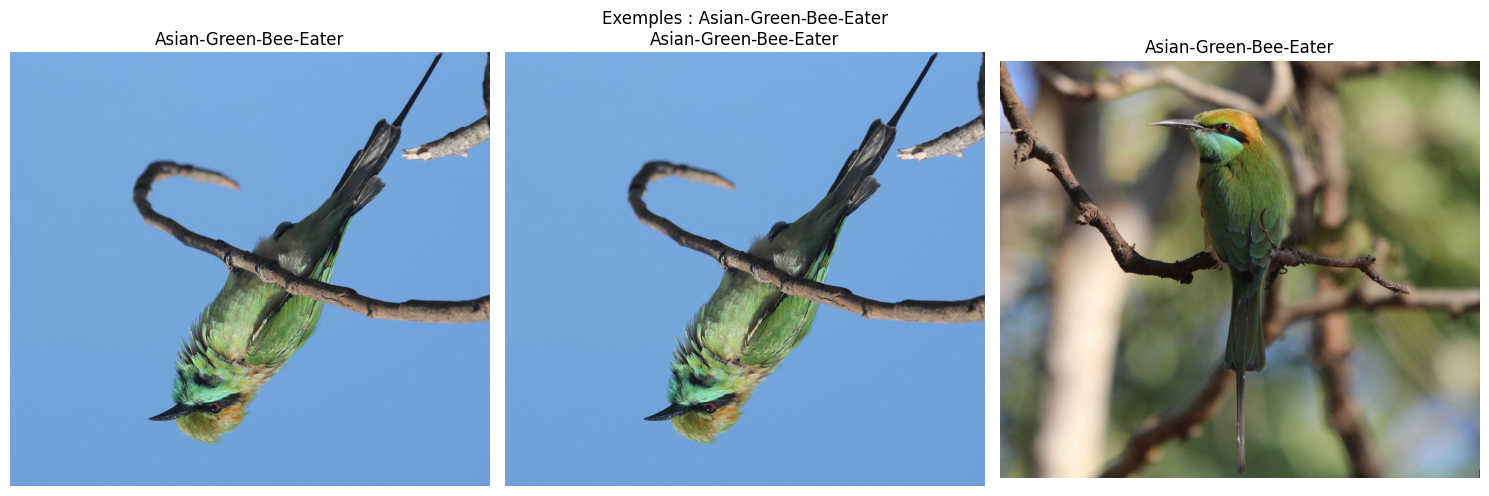


✓ Images affichées avec succès !

✓ Démonstration terminée !


In [4]:
### 4. DÉMONSTRATION - Test du Data Loader ###

print("\n" + "="*80)
print("DÉMONSTRATION DU DATA LOADER")
print("="*80)

try:
    # Récupérer les classes
    train_classes = dataset_loader.get_classes('train')
    valid_classes = dataset_loader.get_classes('valid')
    
    print(f"\n✓ Classes trouvées :")
    print(f"  Entraînement : {len(train_classes)} classes")
    print(f"  Validation : {len(valid_classes)} classes")
    
    # Tester avec la première classe
    if train_classes:
        test_class = train_classes[0]
        print(f"\n✓ Test avec la classe : {test_class}")
        
        # Récupérer les images
        images = dataset_loader.get_images_for_class(test_class, 'train')
        print(f"  Nombre d'images : {len(images)}")
        
        # Charger quelques images
        if images:
            print(f"  Chargement des 3 premières images...")
            loaded = dataset_loader.batch_load_images(test_class, 'train', limit=3)
            print(f"  Images chargées : {len(loaded)}/{3}")
            
            if loaded:
                # Afficher les images
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                for idx, img_data in enumerate(loaded):
                    axes[idx].imshow(img_data['array'])
                    axes[idx].set_title(test_class)
                    axes[idx].axis('off')
                
                plt.tight_layout()
                plt.suptitle(f'Exemples : {test_class}', y=1.02)
                plt.show()
                
                print(f"\n✓ Images affichées avec succès !")

    print("\n✓ Démonstration terminée !")

except Exception as e:
    print(f"\n❌ Erreur lors de la démonstration : {e}")
    import traceback
    traceback.print_exc()

In [ ]:
### 5. PRÉPARATION DES DONNÉES - Chargement direct (sans augmentation) ###

print("\n" + "="*80)
print("PRÉPARATION DES DONNÉES POUR LE DEEP LEARNING")
print("="*80)

# Installation de TensorFlow
print("\n✓ Installation de TensorFlow...")
import subprocess
try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow", "-q"])
    print("  ✓ TensorFlow installé")
except:
    print("  ⚠ TensorFlow déjà installé")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuration GPU - éviter les crashes mémoire
print("\n✓ Configuration GPU...")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"  ✓ GPU détecté : {len(gpus)} GPU(s)")
        print(f"  ✓ Memory growth activé (évite les crashes)")
    except RuntimeError as e:
        print(f"  ⚠ Erreur config GPU : {e}")
else:
    print("  ⚠ Pas de GPU détecté, utilisation du CPU")

print("\n✓ Configuration des paramètres...")

# Paramètres
IMG_SIZE = 224
BATCH_SIZE = 16  # Réduit pour éviter les crashes mémoire
EPOCHS = 20
LEARNING_RATE = 0.001

print(f"  Taille des images : {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch size : {BATCH_SIZE}")
print(f"  Nombre d'epochs : {EPOCHS}")
print(f"  Learning rate : {LEARNING_RATE}")

# Chemins des données
train_dir = Path(dataset_root) / 'train' if dataset_root else TRAIN_PATH
valid_dir = Path(dataset_root) / 'valid' if dataset_root else VALID_PATH

print("\n✓ Chargement des datasets (sans augmentation)...")

try:
    # Générateur simple avec juste rescaling (pas d'augmentation)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2  # 20% pour validation
    )
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Charger les données d'entraînement
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )
    
    # Charger les données de validation (depuis train avec split)
    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )
    
    # Charger les données de test (dossier valid séparé)
    test_generator = test_datagen.flow_from_directory(
        valid_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    # Récupérer les noms de classes
    class_names = list(train_generator.class_indices.keys())
    num_classes = len(class_names)
    
    print(f"\n✓ Datasets créés avec succès !")
    print(f"  Train : {train_generator.samples} images ({len(train_generator)} batches)")
    print(f"  Validation : {val_generator.samples} images ({len(val_generator)} batches)")
    print(f"  Test : {test_generator.samples} images ({len(test_generator)} batches)")
    print(f"  Nombre de classes : {num_classes}")
    print(f"\n  📝 Note : Pas d'augmentation - rescaling uniquement (1/255)")
    
except Exception as e:
    print(f"\n❌ Erreur lors du chargement : {e}")
    import traceback
    traceback.print_exc()
    train_generator = None
    val_generator = None
    test_generator = None
    class_names = None
    num_classes = 0


PRÉPARATION DES DONNÉES POUR LE DEEP LEARNING

✓ Installation de TensorFlow...
  ✓ TensorFlow installé

✓ Configuration GPU...
  ⚠ Pas de GPU détecté, utilisation du CPU

✓ Configuration des paramètres...
  Taille des images : 224x224
  Batch size : 16
  Nombre d'epochs : 20
  Learning rate : 0.001

✓ Chargement des datasets (sans augmentation)...
Found 24000 images belonging to 25 classes.
Found 6000 images belonging to 25 classes.
Found 7500 images belonging to 25 classes.

✓ Datasets créés avec succès !
  Train : 24000 images (1500 batches)
  Validation : 6000 images (375 batches)
  Test : 7500 images (469 batches)
  Nombre de classes : 25

  📝 Note : Pas d'augmentation - rescaling uniquement (1/255)


In [3]:
### 6. CRÉATION DU MODÈLE - Transfer Learning avec MobileNetV2 ###

print("\n" + "="*80)
print("CRÉATION DU MODÈLE - TRANSFER LEARNING")
print("="*80)

if train_generator is None:
    print("\n❌ Les data generators ne sont pas disponibles")
    print("   Exécutez la cellule 5 d'abord")
else:
    from tensorflow.keras.applications import MobileNetV2
    from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
    from tensorflow.keras.models import Model
    
    print("\n✓ Chargement de MobileNetV2 pré-entraîné sur ImageNet...")
    
    # Charger MobileNetV2 sans les couches de classification
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    
    # Geler les couches du modèle de base (transfer learning)
    base_model.trainable = False
    
    print(f"  ✓ MobileNetV2 chargé : {len(base_model.layers)} couches")
    print(f"  ✓ Couches gelées pour transfer learning")
    
    # Construire le modèle complet
    print("\n✓ Construction du classificateur personnalisé...")
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compiler le modèle avec un learning rate adapté au transfer learning
    print("\n✓ Compilation du modèle...")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Afficher le résumé
    total_params = model.count_params()
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    
    print(f"\n📊 Architecture du modèle :")
    print(f"   Base : MobileNetV2 (pré-entraîné ImageNet)")
    print(f"   Paramètres totaux : {total_params:,}")
    print(f"   Paramètres entraînables : {trainable_params:,}")
    print(f"   Paramètres gelés : {total_params - trainable_params:,}")
    print(f"   Classes de sortie : {num_classes}")
    
    # Callbacks optimisés
    print("\n✓ Configuration des callbacks...")
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=1e-7,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'best_model_mobilenet.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1,
            mode='max'
        )
    ]
    
    print(f"\n✓ Modèle Transfer Learning prêt !")
    print(f"   🚀 Ce modèle sera beaucoup plus rapide et précis que le CNN classique")


CRÉATION DU MODÈLE - TRANSFER LEARNING

✓ Chargement de MobileNetV2 pré-entraîné sur ImageNet...
  ✓ MobileNetV2 chargé : 154 couches
  ✓ Couches gelées pour transfer learning

✓ Construction du classificateur personnalisé...

✓ Compilation du modèle...

📊 Architecture du modèle :
   Base : MobileNetV2 (pré-entraîné ImageNet)
   Paramètres totaux : 2,623,065
   Paramètres entraînables : 364,569
   Paramètres gelés : 2,258,496
   Classes de sortie : 25

✓ Configuration des callbacks...

✓ Modèle Transfer Learning prêt !
   🚀 Ce modèle sera beaucoup plus rapide et précis que le CNN classique


In [4]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,623,065 (10.01 MB)

 Trainable params: 364,569 (1.39 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

In [5]:
### 7. ENTRAÎNEMENT - Transfer Learning en 2 phases ###

print("\n" + "="*80)
print("ENTRAÎNEMENT DU MODÈLE - TRANSFER LEARNING")
print("="*80)

if train_generator is None or model is None:
    print("\n❌ Erreur : Les données ou le modèle ne sont pas disponibles")
    print("   Exécutez les cellules 5 et 6 d'abord")
    history = None
else:
    try:
        import time
        
        # Paramètres d'entraînement
        PHASE1_EPOCHS = 5   # Réduire pour test rapide (augmenter à 10 pour production)
        PHASE2_EPOCHS = 5   # Réduire pour test rapide (augmenter à 10 pour production)
        
        # ========== PHASE 1 : Entraîner seulement le classificateur ==========
        print("\n" + "-"*60)
        print("PHASE 1 : Entraînement du classificateur (couches gelées)")
        print("-"*60)
        print(f"  Epochs : {PHASE1_EPOCHS}")
        print(f"  Batches par epoch : {len(train_generator)}")
        
        start_time = time.time()
        
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=PHASE1_EPOCHS,
            callbacks=callbacks,
            verbose=1
        )
        
        phase1_time = time.time() - start_time
        phase1_acc = max(history.history['val_accuracy'])
        print(f"\n✓ Phase 1 terminée en {phase1_time/60:.1f} min")
        print(f"  Meilleure précision validation : {phase1_acc*100:.2f}%")
        
        # ========== PHASE 2 : Fine-tuning des dernières couches ==========
        print("\n" + "-"*60)
        print("PHASE 2 : Fine-tuning (dégel partiel du modèle)")
        print("-"*60)
        
        # Dégeler les 30 dernières couches de MobileNetV2
        base_model.trainable = True
        for layer in base_model.layers[:-30]:
            layer.trainable = False
        
        trainable_count = sum([1 for layer in model.layers if layer.trainable])
        print(f"  ✓ {trainable_count} couches maintenant entraînables")
        print(f"  Epochs : {PHASE2_EPOCHS}")
        
        # Recompiler avec un learning rate plus faible
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Nouveaux callbacks pour fine-tuning
        callbacks_ft = [
            keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=3,
                restore_best_weights=True,
                verbose=1,
                mode='max'
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=2,
                min_lr=1e-8,
                verbose=1
            ),
            keras.callbacks.ModelCheckpoint(
                'best_model_mobilenet_finetuned.h5',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1,
                mode='max'
            )
        ]
        
        start_time = time.time()
        
        history_ft = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=PHASE2_EPOCHS,
            callbacks=callbacks_ft,
            verbose=1
        )
        
        phase2_time = time.time() - start_time
        
        # Combiner les historiques
        for key in history.history:
            history.history[key].extend(history_ft.history[key])
        
        final_acc = max(history_ft.history['val_accuracy'])
        print(f"\n✓ Phase 2 terminée en {phase2_time/60:.1f} min")
        print(f"  Meilleure précision validation : {final_acc*100:.2f}%")
        
        # Résumé final
        print("\n" + "="*60)
        print("RÉSUMÉ DE L'ENTRAÎNEMENT")
        print("="*60)
        total_time = phase1_time + phase2_time
        print(f"  ⏱️ Temps total : {total_time/60:.1f} min")
        print(f"  📈 Précision Phase 1 : {phase1_acc*100:.2f}%")
        print(f"  🎯 Précision Phase 2 : {final_acc*100:.2f}%")
        print(f"  💾 Modèle sauvegardé : best_model_mobilenet_finetuned.h5")
        
    except Exception as e:
        print(f"\n❌ Erreur lors de l'entraînement : {e}")
        import traceback
        traceback.print_exc()
        history = None


ENTRAÎNEMENT DU MODÈLE - TRANSFER LEARNING

------------------------------------------------------------
PHASE 1 : Entraînement du classificateur (couches gelées)
------------------------------------------------------------
  Epochs : 5
  Batches par epoch : 1500
Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.5135 - loss: 1.7123
Epoch 1: val_accuracy improved from None to 0.81300, saving model to best_model_mobilenet.h5



Epoch 1: finished saving model to best_model_mobilenet.h5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 775s 515ms/step - accuracy: 0.6411 - loss: 1.2107 - val_accuracy: 0.8130 - val_loss: 0.6006 - learning_rate: 0.0010
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7589 - loss: 0.7941
Epoch 2: val_accuracy improved from 0.81300 to 0.85533, saving model to best_model_mobilenet.h5



Epoch 2: finished saving model to best_model_mobilenet.h5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 547s 365ms/step - accuracy: 0.7672 - loss: 0.7615 - val_accuracy: 0.8553 - val_loss: 0.4719 - learning_rate: 0.0010
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.8027 - loss: 0.6358
Epoch 3: val_accuracy did not improve from 0.85533
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 340s 226ms/step - accuracy: 0.8023 - loss: 0.6417 - val_accuracy: 0.8505 - val_loss: 0.4877 - learning_rate: 0.0010
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8130 - loss: 0.6034
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_accuracy did not improve from 0.85533
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 289s 193ms/step - accuracy: 0.8112 - loss: 0.6125 - val_accuracy: 0.8510 - val_loss: 0.4818 - learning_rate: 0.0010
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8352 - loss: 0.5264
Epoch 5: val_accuracy improved from 0.85533 to 0.86467


Epoch 5: finished saving model to best_model_mobilenet.h5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 289s 192ms/step - accuracy: 0.8393 - loss: 0.5186 - val_accuracy: 0.8647 - val_loss: 0.4345 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 5.

✓ Phase 1 terminée en 37.3 min
  Meilleure précision validation : 86.47%

------------------------------------------------------------
PHASE 2 : Fine-tuning (dégel partiel du modèle)
------------------------------------------------------------
  ✓ 37 couches maintenant entraînables
  Epochs : 5
Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8040 - loss: 0.6569
Epoch 1: val_accuracy improved from None to 0.87067, saving model to best_model_mobilenet_finetuned.h5



Epoch 1: finished saving model to best_model_mobilenet_finetuned.h5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 358s 234ms/step - accuracy: 0.8290 - loss: 0.5699 - val_accuracy: 0.8707 - val_loss: 0.4424 - learning_rate: 1.0000e-04
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8989 - loss: 0.3293
Epoch 2: val_accuracy improved from 0.87067 to 0.90717, saving model to best_model_mobilenet_finetuned.h5



Epoch 2: finished saving model to best_model_mobilenet_finetuned.h5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 761s 508ms/step - accuracy: 0.8992 - loss: 0.3294 - val_accuracy: 0.9072 - val_loss: 0.3065 - learning_rate: 1.0000e-04
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9278 - loss: 0.2372
Epoch 3: val_accuracy did not improve from 0.90717
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 803s 535ms/step - accuracy: 0.9298 - loss: 0.2322 - val_accuracy: 0.9067 - val_loss: 0.3267 - learning_rate: 1.0000e-04
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9489 - loss: 0.1688
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 4: val_accuracy improved from 0.90717 to 0.91067, saving model to best_model_mobilenet_finetuned.h5



Epoch 4: finished saving model to best_model_mobilenet_finetuned.h5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 618s 412ms/step - accuracy: 0.9464 - loss: 0.1757 - val_accuracy: 0.9107 - val_loss: 0.3238 - learning_rate: 1.0000e-04
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9630 - loss: 0.1228
Epoch 5: val_accuracy improved from 0.91067 to 0.92483, saving model to best_model_mobilenet_finetuned.h5



Epoch 5: finished saving model to best_model_mobilenet_finetuned.h5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 505s 337ms/step - accuracy: 0.9638 - loss: 0.1186 - val_accuracy: 0.9248 - val_loss: 0.2790 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 5.

✓ Phase 2 terminée en 50.8 min
  Meilleure précision validation : 92.48%

RÉSUMÉ DE L'ENTRAÎNEMENT
  ⏱️ Temps total : 88.1 min
  📈 Précision Phase 1 : 86.47%
  🎯 Précision Phase 2 : 92.48%
  💾 Modèle sauvegardé : best_model_mobilenet_finetuned.h5



ÉVALUATION DU MODÈLE

✓ Évaluation sur l'ensemble de test...

📊 Résultats :
   Perte test : 0.1596
   Précision test : 95.44%

✓ Création des graphiques d'entraînement...


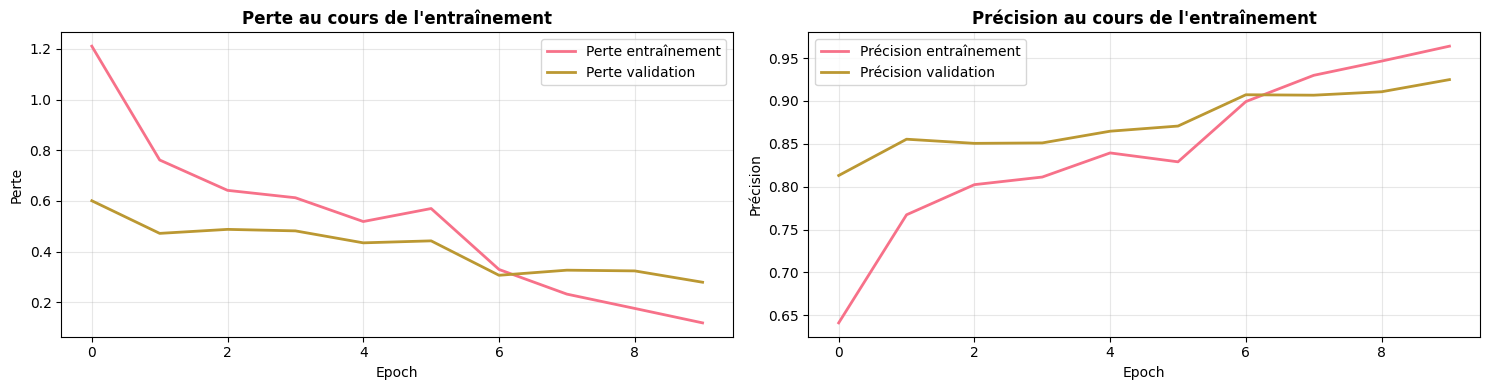


✓ Génération de la matrice de confusion...
469/469 ━━━━━━━━━━━━━━━━━━━━ 77s 162ms/step


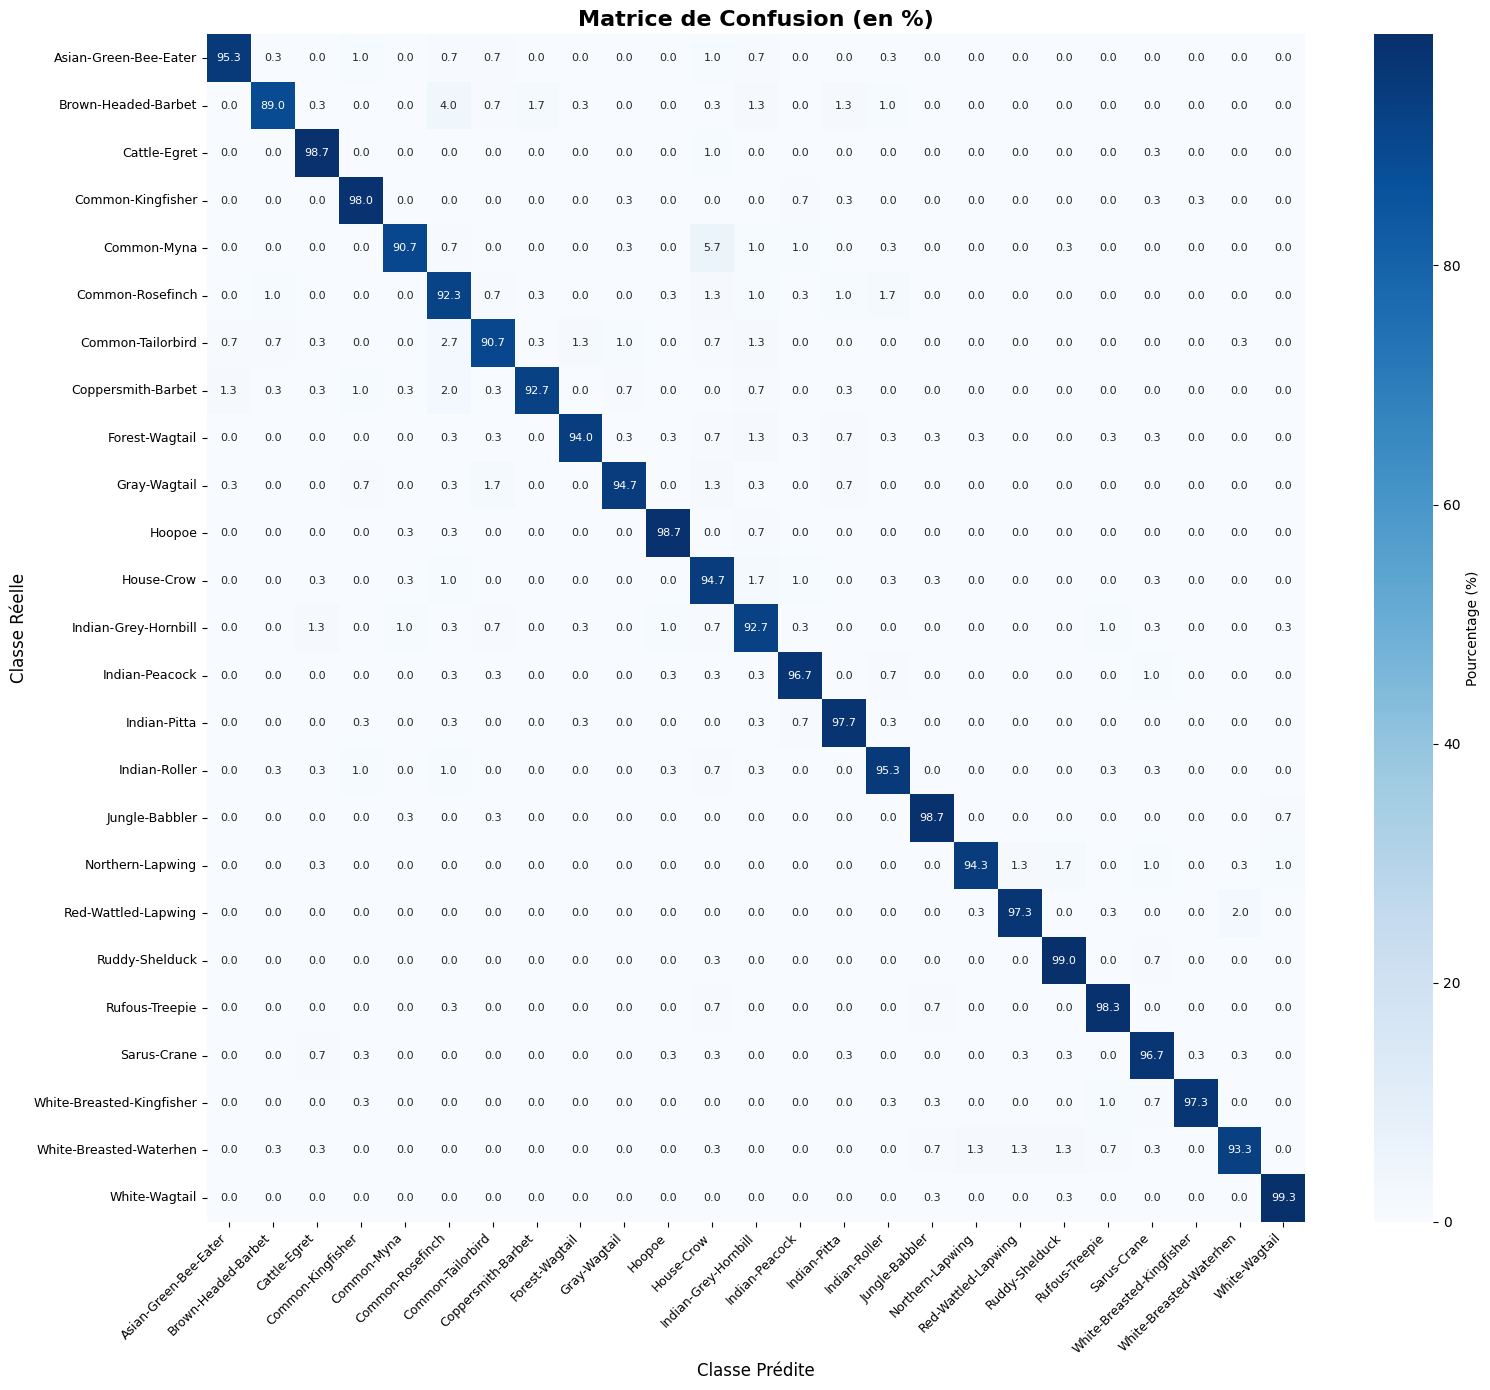


✓ Matrice de confusion affichée !

--------------------------------------------------------------------------------
RAPPORT DE CLASSIFICATION DÉTAILLÉ
--------------------------------------------------------------------------------
                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater      0.976     0.953     0.965       300
      Brown-Headed-Barbet      0.967     0.890     0.927       300
             Cattle-Egret      0.958     0.987     0.972       300
        Common-Kingfisher      0.955     0.980     0.967       300
              Common-Myna      0.975     0.907     0.940       300
         Common-Rosefinch      0.866     0.923     0.894       300
        Common-Tailorbird      0.941     0.907     0.924       300
       Coppersmith-Barbet      0.975     0.927     0.950       300
           Forest-Wagtail      0.976     0.940     0.958       300
             Gray-Wagtail      0.973     0.947     0.959       300
                   Hoopoe    

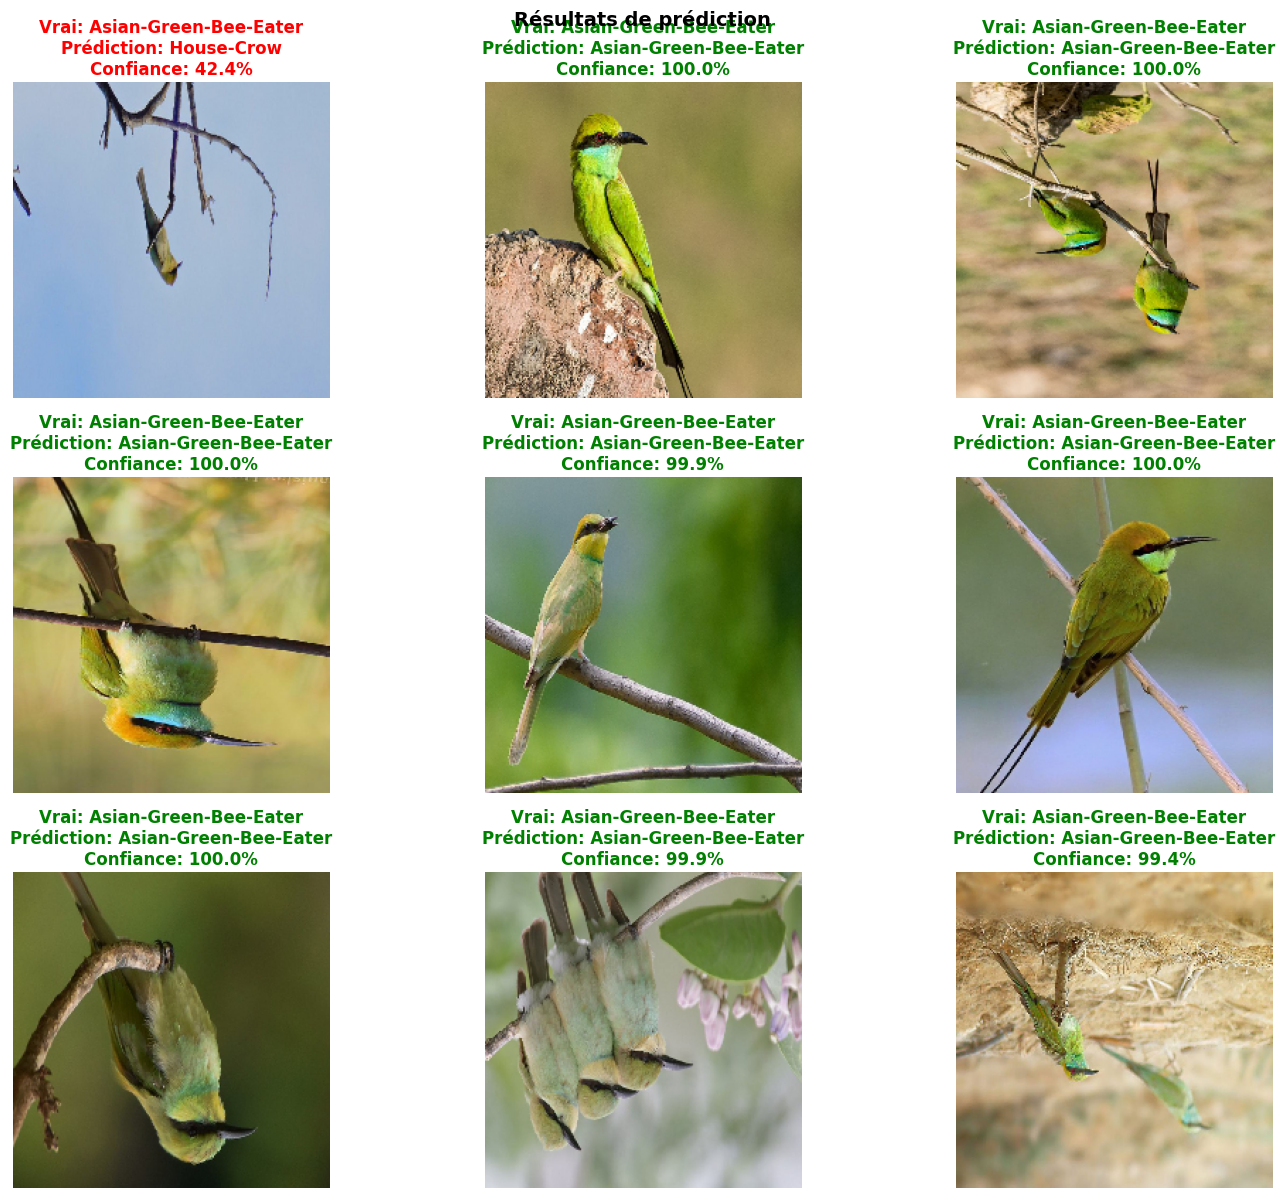


✓ Prédictions affichées !

✓ Évaluation terminée !


In [7]:
### 8. ÉVALUATION - Résultats et visualisation ###

print("\n" + "="*80)
print("ÉVALUATION DU MODÈLE")
print("="*80)

if history is None or model is None:
    print("\n❌ Erreur : L'entraînement n'a pas eu lieu")
    print("   Exécutez la cellule 7 d'abord")
else:
    try:
        from sklearn.metrics import confusion_matrix, classification_report
        
        # Évaluer sur l'ensemble de test
        print("\n✓ Évaluation sur l'ensemble de test...")
        test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
        
        print(f"\n📊 Résultats :")
        print(f"   Perte test : {test_loss:.4f}")
        print(f"   Précision test : {test_accuracy*100:.2f}%")
        
        # Visualiser l'historique d'entraînement
        print("\n✓ Création des graphiques d'entraînement...")
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 4))
        
        # Graphique de la perte
        axes[0].plot(history.history['loss'], label='Perte entraînement', linewidth=2)
        axes[0].plot(history.history['val_loss'], label='Perte validation', linewidth=2)
        axes[0].set_title('Perte au cours de l\'entraînement', fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Perte')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Graphique de la précision
        axes[1].plot(history.history['accuracy'], label='Précision entraînement', linewidth=2)
        axes[1].plot(history.history['val_accuracy'], label='Précision validation', linewidth=2)
        axes[1].set_title('Précision au cours de l\'entraînement', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Précision')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # ========== MATRICE DE CONFUSION ==========
        print("\n✓ Génération de la matrice de confusion...")
        
        # Réinitialiser le générateur de test
        test_generator.reset()
        
        # Récupérer toutes les prédictions
        all_predictions = model.predict(test_generator, verbose=1)
        all_pred_classes = np.argmax(all_predictions, axis=1)
        all_true_classes = test_generator.classes
        
        # Calculer la matrice de confusion
        cm = confusion_matrix(all_true_classes, all_pred_classes)
        
        # Afficher la matrice de confusion
        plt.figure(figsize=(16, 14))
        
        # Normaliser pour afficher les pourcentages
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        
        # Créer le heatmap
        sns.heatmap(cm_normalized, 
                    annot=True, 
                    fmt='.1f', 
                    cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names,
                    cbar_kws={'label': 'Pourcentage (%)'},
                    annot_kws={'size': 8})
        
        plt.title('Matrice de Confusion (en %)', fontsize=16, fontweight='bold')
        plt.xlabel('Classe Prédite', fontsize=12)
        plt.ylabel('Classe Réelle', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.yticks(rotation=0, fontsize=9)
        plt.tight_layout()
        plt.show()
        
        print(f"\n✓ Matrice de confusion affichée !")
        
        # Rapport de classification
        print("\n" + "-"*80)
        print("RAPPORT DE CLASSIFICATION DÉTAILLÉ")
        print("-"*80)
        report = classification_report(all_true_classes, all_pred_classes, 
                                       target_names=class_names, 
                                       digits=3)
        print(report)
        
        # Statistiques par classe
        print("\n" + "-"*80)
        print("STATISTIQUES PAR CLASSE")
        print("-"*80)
        
        # Calculer précision par classe
        class_accuracy = cm.diagonal() / cm.sum(axis=1) * 100
        
        # Créer un DataFrame pour afficher
        stats_df = pd.DataFrame({
            'Classe': class_names,
            'Précision (%)': class_accuracy,
            'Nb Images': cm.sum(axis=1)
        })
        stats_df = stats_df.sort_values('Précision (%)', ascending=False)
        
        print("\n🏆 Top 5 meilleures classes :")
        print(stats_df.head().to_string(index=False))
        
        print("\n⚠️ Top 5 classes à améliorer :")
        print(stats_df.tail().to_string(index=False))
        
        # ========== PRÉDICTIONS VISUELLES ==========
        print("\n✓ Test de prédiction sur des images...")
        
        # Réinitialiser le générateur
        test_generator.reset()
        test_images, test_labels = next(test_generator)
        
        # Faire des prédictions
        predictions = model.predict(test_images[:9], verbose=0)
        pred_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(test_labels[:9], axis=1)
        
        # Afficher les résultats
        fig, axes = plt.subplots(3, 3, figsize=(15, 12))
        axes = axes.flatten()
        
        for idx in range(9):
            img = (test_images[idx] * 255).astype(np.uint8)
            true_label = class_names[true_classes[idx]]
            pred_label = class_names[pred_classes[idx]]
            confidence = predictions[idx][pred_classes[idx]] * 100
            
            axes[idx].imshow(img)
            color = 'green' if true_classes[idx] == pred_classes[idx] else 'red'
            title = f'Vrai: {true_label}\nPrédiction: {pred_label}\nConfiance: {confidence:.1f}%'
            axes[idx].set_title(title, color=color, fontweight='bold')
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.suptitle('Résultats de prédiction', y=0.995, fontsize=14, fontweight='bold')
        plt.show()
        
        print(f"\n✓ Prédictions affichées !")
        print(f"\n✓ Évaluation terminée !")
        
    except Exception as e:
        print(f"\n❌ Erreur lors de l'évaluation : {e}")
        import traceback
        traceback.print_exc()